In [2]:
%matplotlib nbagg
import time
import h5py
import matplotlib.pylab as plt
import numpy as np
import dedalus.public as de
from dedalus.extras import flow_tools

/Users/susanclark/dedalus_upgraded2/dedalus/lib/python3.5/site-packages/IPython/kernel/__init__.py:13: ShimWarning: The `IPython.kernel` package has been deprecated. You should import from ipykernel or jupyter_client instead.
  "You should import from ipykernel or jupyter_client instead.", ShimWarning)


In [3]:
import logging
root = logging.root
for h in root.handlers:
    h.setLevel("INFO")
    
logger = logging.getLogger(__name__)

In [4]:
nr = 128

r_in = 5. # cm
r_out = 3*r_in
h = 10. # cm

nu = 3.26e-3 # cm^2/s
eta = 2000 # cm^2/s
rho = 6 # g/cm^3
B0 = 3000 # G

In [5]:
d = r_out - r_in
eps = h/d
K = np.pi/h * np.sqrt(1+eps**2)
Omega_in = 313.55 # rad/s
Omega_out = 37.9 # rad/s
Re_in = Omega_in/(nu*K**2)
Re_out = Omega_out/(nu*K**2)
zeta_bar = 2*(r_out**2 * Omega_out - r_in**2 * Omega_in)/((r_out**2 - r_in**2)*np.sqrt(Omega_in*Omega_out))
print("Re_in = {}; Re_out = {}".format(Re_in,Re_out))
print("zeta bar = {}".format(zeta_bar))

Re_in = 487258.5449548315; Re_out = 58896.823006819046
zeta bar = 0.06318130680011043


In [6]:
r = de.Chebyshev('r',nr,interval=[r_in, r_out])
domain = de.Domain([r])#,grid_dtype=np.double)

nr2 = 192
r2 = de.Chebyshev('r',nr2,interval=[r_in, r_out])
domain2 = de.Domain([r2])#,grid_dtype=np.double)

In [7]:
r_g = r.grid()

In [8]:
c2 = (Omega_out - Omega_in)/(1/r_out**2 - 1/r_in**2)
c1 = Omega_in - c2/r_in**2

Omega = c1 + c2/r_g**2

In [9]:
omega = domain.new_field()
vorticity = domain.new_field()
r2_omega = domain.new_field()

In [10]:
variables = ['psi', 'u', 'A', 'B', 'psir', 'psirr', 'psirrr', 'ur', 'Ar', 'Br']
gmri1 = de.EVP(domain,variables, 'sigma')
gmri2 = de.EVP(domain2,variables, 'sigma')

for gmri in [gmri1, gmri2]:
    gmri.parameters['nu'] = nu
    gmri.parameters['eta'] = eta
    gmri.parameters['rho'] = rho
    gmri.parameters['B0'] = B0
    gmri.parameters['pi'] = np.pi
    gmri.parameters['k'] = np.pi/h
    gmri.parameters['c1'] = c1
    gmri.parameters['c2'] = c2
    #gmri.substitutions['u0'] = '(c1*r + c2/r)'
    gmri.substitutions['ru0'] = '(r*r*c1 + c2)' # u0 = r Omega(r) = Ar + B/r
    gmri.substitutions['rrdu0'] = '(c1*r*r-c2)' # du0/dr = A - B/r^2
    gmri.substitutions['inv4pirho'] = '(1.0/(4*pi*rho))'
    gmri.substitutions['psivisc'] = '(2*r**2*k**2*psir - 2*r**3*k**2*psirr + r**3*k**4*psi + r**3*dr(psirrr) - 3*psir + 3*r*psirr - 2*r**2*psirrr)'
    gmri.substitutions['uvisc'] = '(-r**3*k**2*u + r**3*dr(ur) + r**2*ur - r*u)'
    gmri.substitutions['Avisc'] = '(r*dr(Ar) - r*k**2*A - Ar)' # checked on whiteboard 5/6
    gmri.substitutions['Bvisc'] = '(-r**3*k**2*B + r**3*dr(Br) + r**2*Br - r*B)'

2016-06-30 13:50:49,084 problems 0/1 INFO :: Solving EVP with homogeneity tolerance of 1.000e-10
2016-06-30 13:50:49,085 problems 0/1 INFO :: Solving EVP with homogeneity tolerance of 1.000e-10


In [11]:
for gmri in [gmri1, gmri2]:
    gmri.add_equation("sigma*(-r**3*k**2*psi + r**3*psirr - r**2*psir) - r**2*2*ru0*1j*k*u + r**3*inv4pirho*B0*1j*k**3*A + inv4pirho*B0*r**2*1j*k*Ar - inv4pirho*r**3*B0*1j*k*dr(Ar) - nu*psivisc = 0") #corrected on whiteboard 5/6
    gmri.add_equation("sigma*r**3*u + 1j*k*ru0*psi + 1j*k*rrdu0*psi - 1j*k*r**3*inv4pirho*B0*B - nu*uvisc = 0") # correct 5/5
    gmri.add_equation("sigma*r*A - r*B0*1j*k*psi - eta*Avisc = 0")
    gmri.add_equation("sigma*r**3*B + ru0*1j*k*A - r**3*B0*1j*k*u - 1j*k*rrdu0*A - eta*Bvisc = 0") # correct 5/5

In [12]:
for gmri in [gmri1, gmri2]:
    gmri.add_equation("dr(psi) - psir = 0")
    gmri.add_equation("dr(psir) - psirr = 0")
    gmri.add_equation("dr(psirr) - psirrr = 0")
    gmri.add_equation("dr(u) - ur = 0")
    gmri.add_equation("dr(A) - Ar = 0")
    gmri.add_equation("dr(B) - Br = 0")

In [13]:
for gmri in [gmri1, gmri2]:
    gmri.add_bc('left(u) = 0')
    gmri.add_bc('right(u) = 0')
    gmri.add_bc('left(psi) = 0')
    gmri.add_bc('right(psi) = 0')
    gmri.add_bc('left(A) = 0')
    gmri.add_bc('right(A) = 0')
    gmri.add_bc('left(psir) = 0')
    gmri.add_bc('right(psir) = 0')
    gmri.add_bc('left(dr(r*B)) = 0')
    gmri.add_bc('right(dr(r*B)) = 0')

In [14]:
gmri_solver1 = gmri1.build_solver()
gmri_solver2 = gmri2.build_solver()

In [15]:
#gmri_solver1.problem.substitutions

In [16]:
gmri_solver1.solve(gmri_solver1.pencils[0])
gmri_solver2.solve(gmri_solver2.pencils[0])

/Users/susanclark/dedalus_upgraded2/dedalus/lib/python3.5/site-packages/scipy/linalg/decomp.py:56: RuntimeWarning: divide by zero encountered in true_divide
  w = alpha / beta
/Users/susanclark/dedalus_upgraded2/dedalus/lib/python3.5/site-packages/scipy/linalg/decomp.py:56: RuntimeWarning: invalid value encountered in true_divide
  w = alpha / beta


In [17]:
def discard_spurious_eigenvalues(lambda1, lambda2):

    """
    lambda1 :: eigenvalues from low res run
    lambda2 :: eigenvalues from high res run

    Solves the linear eigenvalue problem for two different resolutions.
    Returns trustworthy eigenvalues using nearest delta, from Boyd chapter 7.
    """

    # Reverse engineer correct indices to make unsorted list from sorted
    reverse_lambda1_indx = np.arange(len(lambda1)) 
    reverse_lambda2_indx = np.arange(len(lambda2))

    lambda1_and_indx = np.asarray(list(zip(lambda1, reverse_lambda1_indx)))
    lambda2_and_indx = np.asarray(list(zip(lambda2, reverse_lambda2_indx)))

    # remove nans
    lambda1_and_indx = lambda1_and_indx[np.isfinite(lambda1)]
    lambda2_and_indx = lambda2_and_indx[np.isfinite(lambda2)]

    # Sort lambda1 and lambda2 by real parts
    lambda1_and_indx = lambda1_and_indx[np.argsort(lambda1_and_indx[:, 0].real)]
    lambda2_and_indx = lambda2_and_indx[np.argsort(lambda2_and_indx[:, 0].real)]

    lambda1_sorted = lambda1_and_indx[:, 0]
    lambda2_sorted = lambda2_and_indx[:, 0]

    # Compute sigmas from lower resolution run (gridnum = N1)
    sigmas = np.zeros(len(lambda1_sorted))
    sigmas[0] = np.abs(lambda1_sorted[0] - lambda1_sorted[1])
    sigmas[1:-1] = [0.5*(np.abs(lambda1_sorted[j] - lambda1_sorted[j - 1]) + np.abs(lambda1_sorted[j + 1] - lambda1_sorted[j])) for j in range(1, len(lambda1_sorted) - 1)]
    sigmas[-1] = np.abs(lambda1_sorted[-2] - lambda1_sorted[-1])

    if not (np.isfinite(sigmas)).all():
        print("WARNING: at least one eigenvalue spacings (sigmas) is non-finite (np.inf or np.nan)!")

    # Nearest delta
    delta_near = np.array([np.nanmin(np.abs(lambda1_sorted[j] - lambda2_sorted)/sigmas[j]) for j in range(len(lambda1_sorted))])

    # Discard eigenvalues with 1/delta_near < 10^6
    lambda1_and_indx = lambda1_and_indx[np.where((1.0/delta_near) > 1E6)]
    #print(lambda1_and_indx)

    lambda1 = lambda1_and_indx[:, 0]
    indx = lambda1_and_indx[:, 1]

    return lambda1, indx

In [18]:
# Discard spurious eigenvalues
ev1 = gmri_solver1.eigenvalues
ev2 = gmri_solver2.eigenvalues
goodeigs, goodeigs_indices = discard_spurious_eigenvalues(ev1, ev2)

In [19]:
goodeigs_index = np.nanargmax(goodeigs.real)
marginal_mode_index = int(goodeigs_indices[goodeigs_index])

gmri_solver1.set_state(marginal_mode_index)

/Users/susanclark/dedalus_upgraded2/dedalus/lib/python3.5/site-packages/ipykernel/__main__.py:2: ComplexWarning: Casting complex values to real discards the imaginary part
  from ipykernel import kernelapp as app


In [20]:
goodeigs[goodeigs_index]

(0.012057860301685338+1.1908432326928659e-10j)

In [21]:
np.nanmin(np.abs(goodeigs.real))

0.012057860301685338

In [113]:
k = gmri1.parameters['k']
print("vertical wavenumber is {}".format(k))

u = (-(1j*k*(1/r_g)*gmri_solver1.state['psi']['g'])).real
v = (-gmri_solver1.state['u']['g']).real
w = (((-1/r_g)*gmri_solver1.state['psir']['g'])).real
Br = ((1j*k*(1/r_g)*gmri_solver1.state['A']['g'])).real
Bphi = (gmri_solver1.state['B']['g']).real
Bz = (-((-1/r_g)*gmri_solver1.state['Ar']['g'])).real


#scale_factor = 2.7/np.abs(v.real).max()
#scale_factor = 2.7/v.max()
#scale_factor = -2.7/np.abs(v.real).max()
#scale_factor = 2.7/np.abs(v.real).max()

# Normalize all real or imag
n = np.abs(gmri_solver1.state['psi']['g'])[13]
a = gmri_solver1.state['psi']['g'].real[13]/n
b = gmri_solver1.state['psi']['g'].imag[13]/n
scale = 1j*a/(b*(a**2/b+b)) + 1./(a**2/b +b)

print(scale)

#scale_factor = -2.7/np.abs(v.real).max()
#scale_factor = 2.7/v[np.argmax(np.abs(v.real))]
#scale_factor = 2.7/np.abs(v.real).max()
scale_factor = 2.7/v.real.max()
#scale_factor = 2.7/v[np.argmax(v)]

print("scaling by {}".format(scale_factor))
print(v.real.max(), v.max())

vertical wavenumber is 0.3141592653589793
(0.9976381622622661-0.06868840657613419j)
scaling by 23024.42166063318
0.000117266789142 0.000117266789142


/Users/susanclark/dedalus_upgraded2/dedalus/lib/python3.5/site-packages/matplotlib-1.4.3-py3.5-macosx-10.9-x86_64.egg/matplotlib/pyplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


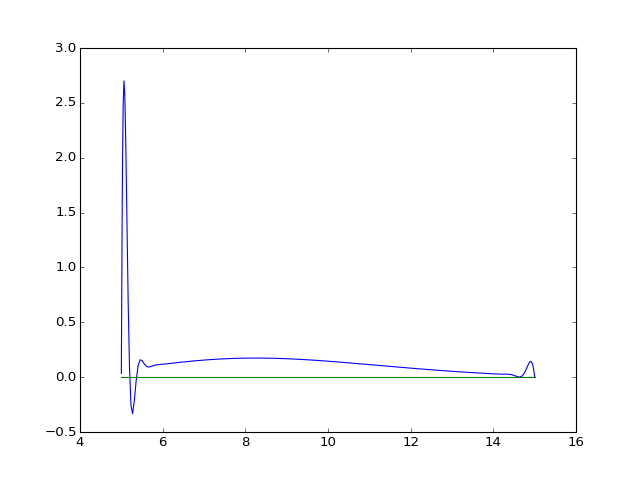

In [114]:
fig = plt.figure()
plt.plot(r_g, v.real*scale_factor)
plt.plot(r_g, v.imag*scale_factor)
#plt.plot(r_g, gmri_solver1.state['psir']['g'], '.')

/Users/susanclark/dedalus_upgraded2/dedalus/lib/python3.5/site-packages/matplotlib-1.4.3-py3.5-macosx-10.9-x86_64.egg/matplotlib/pyplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


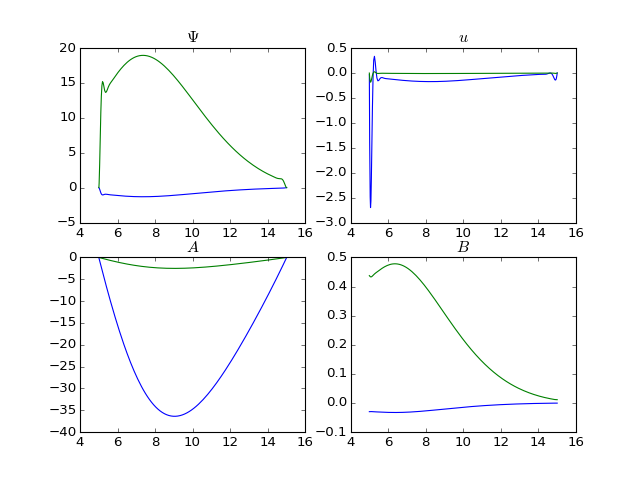

/Users/susanclark/dedalus_upgraded2/dedalus/lib/python3.5/site-packages/numpy/core/numeric.py:460: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


In [65]:
fig = plt.figure()
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)
ax1.plot(r_g, scale_factor*gmri_solver1.state['psi']['g'])
ax1.plot(r_g, scale_factor*gmri_solver1.state['psi']['g'].imag)
ax1.set_title(r"$\Psi$")
ax2.plot(r_g, scale_factor*gmri_solver1.state['u']['g'])
ax2.plot(r_g, scale_factor*gmri_solver1.state['u']['g'].imag)
ax2.set_title(r"$u$")
ax3.plot(r_g, scale_factor*gmri_solver1.state['A']['g'])
ax3.plot(r_g, scale_factor*gmri_solver1.state['A']['g'].imag)
ax3.set_title(r"$A$")
ax4.plot(r_g, scale_factor*gmri_solver1.state['B']['g'])
ax4.plot(r_g, scale_factor*gmri_solver1.state['B']['g'].imag)
ax4.set_title(r"$B$")
#plt.plot(r_g, Bphi*scale_factor*5)
#plt.plot(r_g,scale_factor*Br.imag)
#plt.plot(r_g, Br)
#plt.plot(r_g, Bz)
#plt.ylim(-0.4, 0.4)
#Br*scale_factor

In [115]:
len(v)

128

/Users/susanclark/dedalus_upgraded2/dedalus/lib/python3.5/site-packages/matplotlib-1.4.3-py3.5-macosx-10.9-x86_64.egg/matplotlib/pyplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


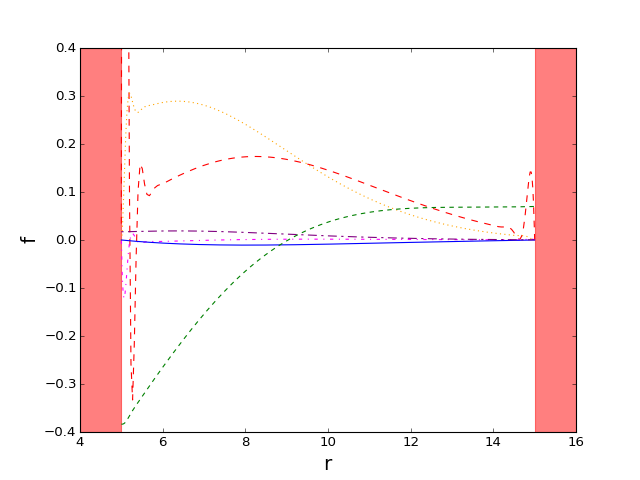

(-0.4, 0.4)

In [119]:
plt.figure()
plt.plot(r_g,scale_factor*v,'k',ls='--', color = "red")
plt.plot(r_g,scale_factor*u/3.,'k',ls='dotted', color = "orange")
plt.plot(r_g,-scale_factor*w*0.07,'k',ls='-.', color = "magenta")
plt.plot(r_g,-scale_factor*Br/np.sqrt(4*np.pi*rho),'k', color = "blue")
plt.plot(r_g,-scale_factor*Bphi/np.sqrt(4*np.pi*rho)*5,'k',dashes=[2,4,8,4], color = "purple")
plt.plot(r_g,scale_factor*Bz/np.sqrt(4*np.pi*rho),'k',dashes=[4,4], color = "green")
plt.xlabel('r', fontsize=18)
plt.ylabel('f', fontsize=18)
plt.axvspan(4, 5, alpha=0.5, color='red')
plt.axvspan(15, 16, alpha=0.5, color='red')

plt.xlim(4,16)
plt.ylim(-0.4,0.4)
#plt.ylim(-0.3, 0.3)
#plt.ylim(-0.4,0.4)

# pink, purple and blue look shitty: that's uz, Br and Bphi

/Users/susanclark/dedalus_upgraded2/dedalus/lib/python3.5/site-packages/matplotlib-1.4.3-py3.5-macosx-10.9-x86_64.egg/matplotlib/pyplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


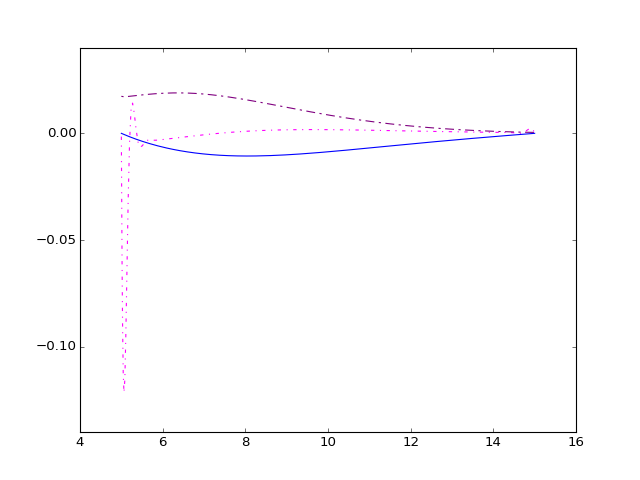

(-0.14, 0.04)

In [123]:
plt.figure()
plt.plot(r_g,-scale_factor*w*0.07,'k',ls='-.', color = "magenta")
plt.plot(r_g,-scale_factor*Br/np.sqrt(4*np.pi*rho),'k', color = "blue")
plt.plot(r_g,-scale_factor*Bphi/np.sqrt(4*np.pi*rho)*5,'k',dashes=[2,4,8,4], color = "purple")
plt.ylim(-.14, 0.04)

<IPython.core.display.Javascript object>


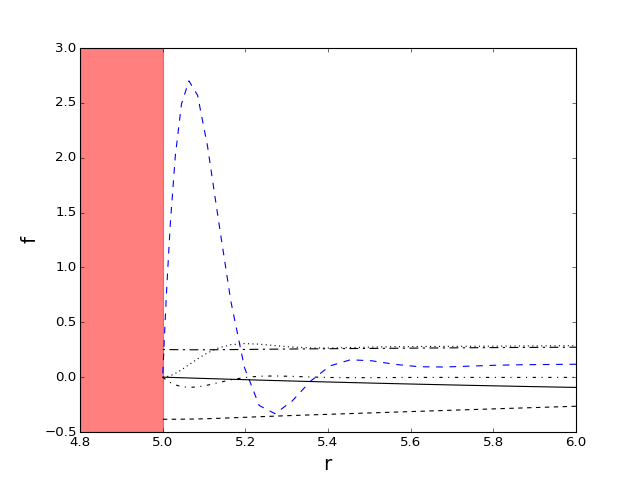

(-0.5, 3)

In [37]:
plt.figure()
plt.plot(r_g,scale_factor*v,'b',ls='--')
plt.plot(r_g,scale_factor*u/3,'k',ls='dotted')
plt.plot(r_g,scale_factor*w*0.07,'k',ls='-.')
plt.plot(r_g,scale_factor*Br/np.sqrt(4*np.pi*rho),'k')
plt.plot(r_g,scale_factor*Bphi/np.sqrt(4*np.pi*rho)*5,'k',dashes=[2,4,8,4])
plt.plot(r_g,scale_factor*Bz/np.sqrt(4*np.pi*rho),'k',dashes=[4,4])
plt.xlabel('r', fontsize=18)
plt.ylabel('f', fontsize=18)
plt.axvspan(4.8, 5, alpha=0.5, color='red')

plt.xlim(4.8,6)
plt.ylim(-0.5,3)

In [27]:
v

array([ -1.48663286e-06 -7.88839936e-08j,
        -1.30022718e-05 -6.89853430e-07j,
        -3.40332950e-05 -1.80545969e-06j,
        -6.06750292e-05 -3.21819460e-06j,
        -8.74721179e-05 -4.63928087e-06j,
        -1.08230668e-04 -5.74062826e-06j,
        -1.17379423e-04 -6.22584789e-06j,
        -1.11672905e-04 -5.92318343e-06j,
        -9.16133480e-05 -4.85912523e-06j,
        -6.18404125e-05 -3.27995932e-06j,
        -2.99384365e-05 -1.58800326e-06j,
        -3.82591579e-06 -2.02927221e-07j,
         1.12288273e-05 +5.95582754e-07j,
         1.44864482e-05 +7.68397894e-07j,
         9.45752862e-06 +5.01581302e-07j,
         1.62697691e-06 +8.62994260e-08j,
        -4.43539872e-06 -2.35216579e-07j,
        -6.87962051e-06 -3.64941467e-07j,
        -6.46530076e-06 -3.42889809e-07j,
        -5.06957693e-06 -2.68898416e-07j,
        -4.12968648e-06 -2.19042340e-07j,
        -4.01517619e-06 -2.12957210e-07j,
        -4.36372706e-06 -2.31457377e-07j,
        -4.72788118e-06 -2.5076257

<IPython.core.display.Javascript object>


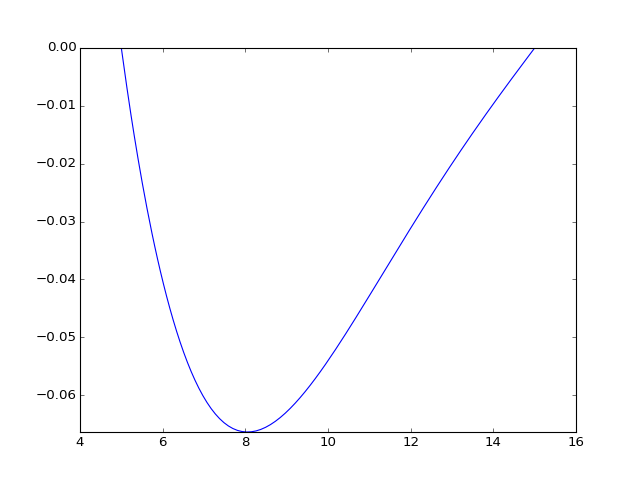

(-0.066368176828351291, -3.5511875329518419e-06)

In [75]:
# Test if this is just a scaling issue by comparing self-scaled shapes with primitive-run LEV eigenfunctions
plt.figure()
plt.plot(z_g,scale_factor*w['g']*0.07,'k',ls='-.', color = "magenta")
plt.plot(r_g,-scale_factor*Br/np.sqrt(4*np.pi*rho),'k', color = "blue")
plt.ylim(np.min(-scale_factor*Br/np.sqrt(4*np.pi*rho)), np.max(-scale_factor*Br/np.sqrt(4*np.pi*rho)))

<IPython.core.display.Javascript object>


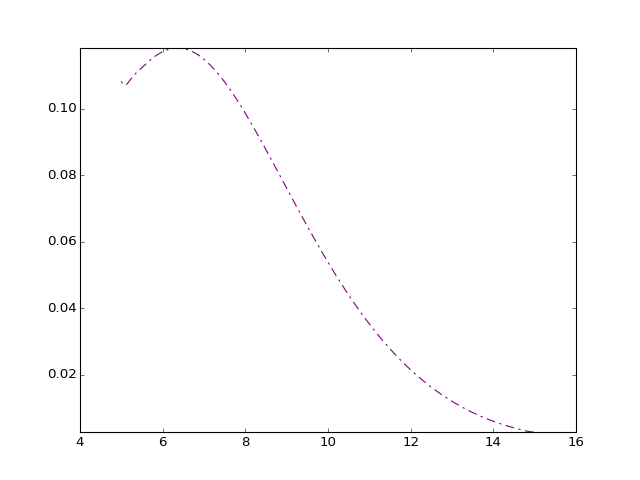

(0.0027510580598084462, 0.11833118936603376)

In [81]:
plt.figure()
plt.plot(r_g, -scale_factor*Bphi/np.sqrt(4*np.pi*rho)*5,'k',dashes=[2,4,8,4], color = "purple")
plt.ylim(np.min(-scale_factor*Bphi/np.sqrt(4*np.pi*rho)*5), np.max(-scale_factor*Bphi/np.sqrt(4*np.pi*rho)*5))